# Source code

In [53]:
library(dplyr)
library(ggplot2)
library(tidyselect)

## 1. Quality Control

## Sample QC

### Identification of individuals with elevated missing data rates or outlying heterozygosity rates

Bash commands:   
`plink --bfile eye_color --missing --allow-no-sex --out eye_color_QC`

`plink --bfile eye_color --het --allow-no-sex --out eye_color_QC`

In [4]:
#missing data
d_miss <- read.table("eye_color_QC.imiss",header=T)

#heterozygosity
d_het <- read.table("eye_color_QC.het",header=T)

#join the two tables
d <- inner_join(d_miss,d_het)

#calculate the observed heterozygosity rate per individual
d <- d %>% mutate(het_rate = (N.NM.-O.HOM.)/N.NM.)
#N.NM is the number of non-missing genotypes pr individual and O.HOM is the observed number of homozygous genotypes.

head(d)

Joining, by = c("FID", "IID")



,FID,IID,MISS_PHENO,N_MISS,N_GENO,F_MISS,O.HOM.,E.HOM.,N.NM.,F,het_rate
,<int>,<int>,<chr>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>
1,1010,1010,Y,417559,958847,0.435500,355012,353100,522943,0.011510,0.3211268
2,1013,1013,Y,1589,958847,0.001657,622171,618900,897402,0.011880,0.3066976
3,1020,1020,Y,3555,958847,0.003708,620700,617700,895619,0.010850,0.3069598
4,1022,1022,Y,23735,958847,0.024750,609152,605200,877300,0.014590,0.3056514
5,1024,1024,Y,23896,958847,0.024920,606768,605000,876929,0.006683,0.3080763
6,1026,1026,Y,23264,958847,0.024260,611711,605300,877569,0.023400,0.3029483


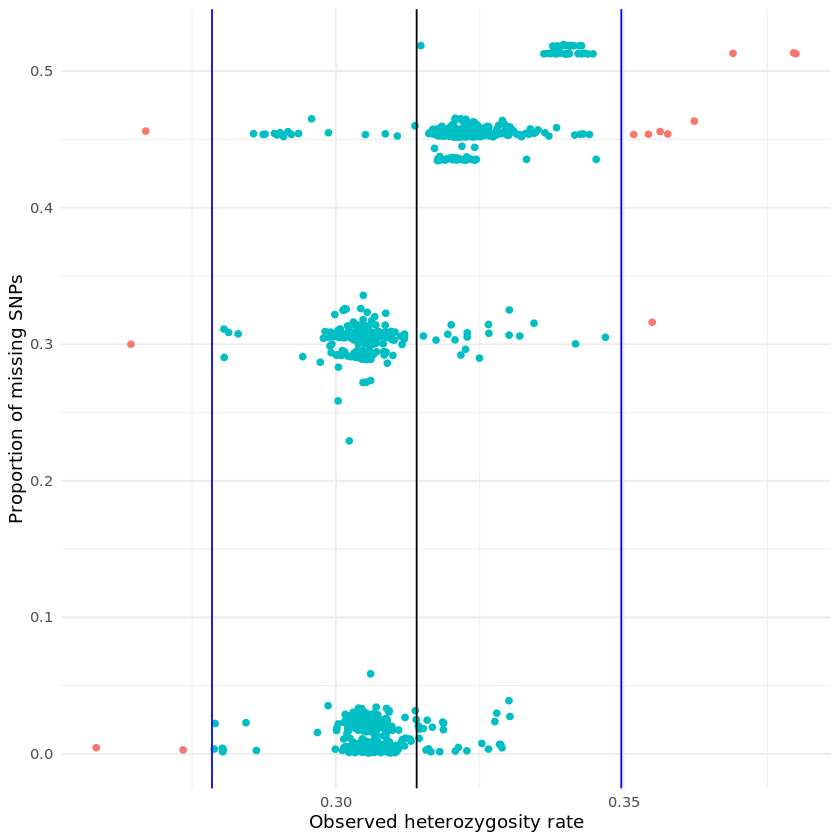

In [5]:
#plotting the observed heterozygosity rate against the proportion of missing SNPs
mean_heterozygosiy  <- mean(d$het_rate)
sd_heterozygosity  <- sd(d$het_rate)

d  %>% mutate(bounds = abs(het_rate-mean_heterozygosiy) < 3*sd_heterozygosity) %>% 
ggplot()+
geom_point(aes(x = het_rate,y = F_MISS, color = bounds)) +
geom_vline(xintercept = mean_heterozygosiy, color ="black") +
geom_vline(xintercept = mean_heterozygosiy-3*sd_heterozygosity, color ="blue") +
geom_vline(xintercept = mean_heterozygosiy+3*sd_heterozygosity, color ="blue") +  
theme_minimal() + theme(legend.position = "none") +
xlab("Observed heterozygosity rate") + ylab("Proportion of missing SNPs")

In [6]:
#write out the individuals that should be removed due to outlying heterozygosity rates
tofilter <- d %>% 
    filter(abs(het_rate-mean_heterozygosiy) > 3*sd_heterozygosity)
tofilter

tofilter %>% 
    select(FID, IID) %>% 
    write.table(file = "wrong_het_missing_values.txt", sep = "\t", row.names = FALSE, col.names = FALSE)

FID,IID,MISS_PHENO,N_MISS,N_GENO,F_MISS,O.HOM.,E.HOM.,N.NM.,F,het_rate
<int>,<int>,<chr>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>
2053,2053,Y,287683,958847,0.300000,481143,451900,654052,0.14450,0.2643658
2887,2887,Y,437005,958847,0.455800,318819,333900,495340,-0.09349,0.3563633
2907,2907,Y,437299,958847,0.456100,362792,333600,494902,0.18080,0.2669417
3783,3783,Y,444472,958847,0.463500,311908,329600,489119,-0.11110,0.3623065
4006,4006,Y,435150,958847,0.453800,320729,334900,496740,-0.08743,0.3543322
44,44,Y,2768,958847,0.002887,651807,618700,897111,0.11900,0.2734377
483,483,Y,4333,958847,0.004519,664180,617600,895527,0.16770,0.2583362
5867,5867,Y,303054,958847,0.316100,402855,431800,624571,-0.15020,0.3549893
5989,5989,Y,435297,958847,0.454000,319130,334900,496846,-0.09762,0.3576883


Bash commands:  
`plink --bfile eye_color --allow-no-sex --remove wrong_het_missing_values.txt "--make-bed" --out eye_color_QC`

### Identification of related individuals
Bash commands:  
`plink --bfile eye_color_QC --allow-no-sex --indep-pairwise 500kb 5 0.2 --out eye_color_QC`  
`plink --bfile eye_color_QC --allow-no-sex --extract eye_color_QC.prune.in --genome --min 0.185 --out eye_color_QC`  


In [7]:
ibd <- read.table('eye_color_QC.genome', header = TRUE)
ibd
members <- ibd$FID1 #we will remove individuals in the first column
members <- unique(members)
print("removed individuals:")
print(members)
write.table(cbind(members,members), file = 'wrong_ibd.txt', col.names = F, row.names = F)

FID1,IID1,FID2,IID2,RT,EZ,Z0,Z1,Z2,PI_HAT,PHE,DST,PPC,RATIO
<int>,<int>,<int>,<int>,<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1173,1173,4814,4814,UN,NA,0.0000,0.0000,1.0000,1.0000,-1,1.000000,1,NA
1269,1269,1275,1275,UN,NA,0.0016,0.9596,0.0388,0.5186,-1,0.873349,1,1843.5000
1424,1424,6035,6035,UN,NA,0.0000,0.0000,1.0000,1.0000,-1,1.000000,1,NA
1775,1775,2083,2083,UN,NA,0.0000,0.0000,1.0000,1.0000,-1,1.000000,1,NA
2651,2651,912,912,UN,NA,0.0019,0.9757,0.0225,0.5103,-1,0.871179,1,1147.6667
3998,3998,6191,6191,UN,NA,0.0000,0.0000,1.0000,1.0000,-1,1.000000,1,NA
4460,4460,5895,5895,UN,NA,0.0000,0.0000,1.0000,1.0000,-1,1.000000,1,NA
4547,4547,4632,4632,UN,NA,0.5345,0.4655,0.0000,0.2327,-1,0.804813,1,4.2488
4583,4583,4584,4584,UN,NA,0.2415,0.5295,0.2290,0.4938,-1,0.879323,1,10.9805


[1] "removed individuals:"
 [1] 1173 1269 1424 1775 2651 3998 4460 4547 4583 4584 5792  651 8915 9277


Bash commands:  
`plink --bfile eye_color_QC --allow-no-sex --remove wrong_ibd.txt --make-bed --out eye_color_QC`

## SNP QC

### Identification of SNPs with excessive missing data rates

Bash commands:   
`plink --bfile eye_color_QC --missing --allow-no-sex --out eye_color_QC`   


,CHR,SNP,N_MISS,N_GENO,F_MISS
,<int>,<chr>,<int>,<int>,<dbl>
1,1,rs4477212,618,1260,0.49050
2,1,rs3094315,699,1260,0.55480
3,1,rs3131972,41,1260,0.03254
4,1,rs12124819,272,1260,0.21590
5,1,rs11240777,35,1260,0.02778
6,1,rs6681049,584,1260,0.46350


Warning message:
“Removed 1766 rows containing non-finite values (stat_bin).”


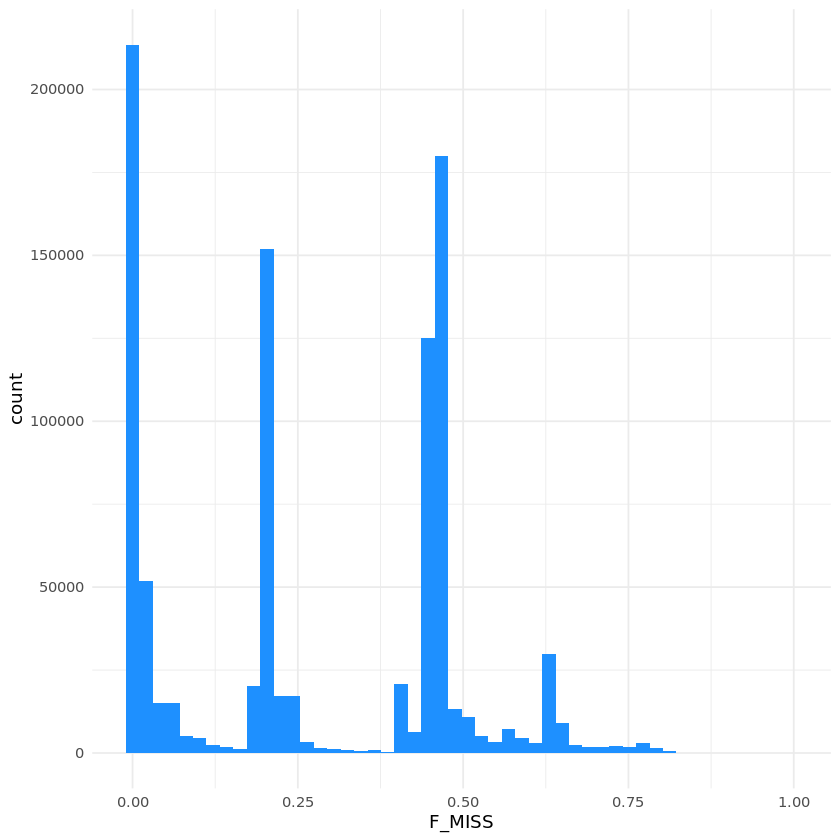

In [8]:
lmiss <- read.table("eye_color_QC.lmiss", header = T) ##CHANGE AXIS AND COLOR
head(lmiss)
lmiss %>%
    ggplot(aes(x=F_MISS)) +
    geom_histogram(bins=50,fill="dodgerblue") + theme_minimal()

Bash commands:  
`plink --bfile eye_color_QC --geno 0.75 --hwe 0.00001 --maf 0.01 --make-bed --allow-no-sex --out eye_color_QC`

## 2. Creating a binary phenotype

In [128]:
eyecolor_qc <- read.table("eye_color_QC.fam")
colnames(eyecolor_qc) <- c("FID","IID","PAT","MAT","SEX","PHENO")
head(eyecolor_qc)
phenotype <- read.table("eye_color.txt") 
colnames(phenotype) <- c("FID", "PHENO")
head(phenotype)

,FID,IID,PAT,MAT,SEX,PHENO
,<int>,<int>,<int>,<int>,<int>,<int>
1,1010,1010,0,0,0,-9
2,1013,1013,0,0,0,-9
3,1020,1020,0,0,0,-9
4,1022,1022,0,0,0,-9
5,1024,1024,0,0,0,-9
6,1026,1026,0,0,0,-9


,FID,PHENO
,<int>,<chr>
1,1010,brown
2,1013,hazel/brown-green
3,1020,blue
4,1022,blue-green
5,1024,blue
6,1026,hazel/brown-green


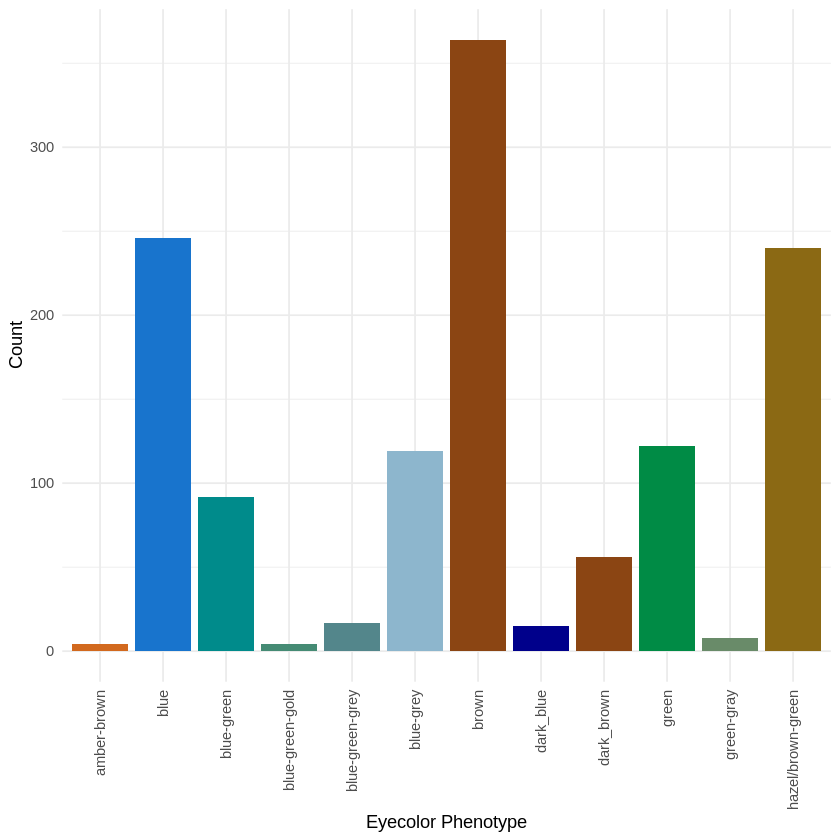

In [129]:
ggplot(phenotype) +
    geom_bar(aes(x = PHENO, fill = PHENO)) +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
          legend.position = "none") +
    xlab("Eyecolor Phenotype") + ylab("Count") +
    scale_fill_manual(values=c("chocolate", "dodgerblue3", "cyan4", "aquamarine4", "cadetblue4", "lightskyblue3", "saddlebrown", "darkblue", "chocolate4", "springgreen4", "darkseagreen4", "goldenrod4"))

In [130]:
phenotype$PHENO <- ifelse(grepl("brown", phenotype$PHENO),'1','2') #1 is all phenotypes containing the word brown, 2 is the leftover phenotypes (green, blue, gray)
phenotype %>% head()
phenotype %>% write.table(file = "binary_phenotypes.txt", sep = "\t", row.names = FALSE, col.names = FALSE)


,FID,PHENO
,<int>,<chr>
1,1010,1
2,1013,1
3,1020,2
4,1022,2
5,1024,2
6,1026,1


In [135]:
eyecolor_qc$PHENO <- phenotype$PHENO[match(eyecolor_qc$FID, phenotype$FID)]
dim(eyecolor_qc)
head(eyecolor_qc)
eyecolor_qc %>% group_by(PHENO) %>% summarise(count = n())

[1] 1260    6

,FID,IID,PAT,MAT,SEX,PHENO
,<int>,<int>,<int>,<int>,<int>,<chr>
1,1010,1010,0,0,0,1
2,1013,1013,0,0,0,1
3,1020,1020,0,0,0,2
4,1022,1022,0,0,0,2
5,1024,1024,0,0,0,2
6,1026,1026,0,0,0,1


,PHENO,count
,<chr>,<int>
1,1,646
2,2,614
